In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

In [2]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x=X[y == cl, 0],
            y=X[y == cl, 1],
            alpha=0.8,
            c=colors[idx],
            marker=markers[idx],
            label=cl,
            edgecolor='black'
        )
        
    # highlight test examples
    if test_idx:
        # plot all examples
        X_test= X[test_idx, :]
        y_test = y[test_idx]
        plt.scatter(
            X_test[:, 0], 
            X_test[:, 1],
            c=[],
            edgecolor='black',
            alpha=1,
            linewidth=1, 
            marker='o',
            s=100, 
            label='test set'
        )

In [3]:
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
print('Class labels:', np.unique(y))

Class labels: [0 1 2]


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [5]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y:', np.bincount(y_train))
print('Labels counts in y:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y: [35 35 35]
Labels counts in y: [15 15 15]


In [6]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [7]:
ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=1)

In [8]:
y_pred = ppn.predict(X_test_std)
print('Misclassified examples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Accuracy: %.3f' % ppn.score(X_test_std, y_test))

Misclassified examples: 1
Accuracy: 0.978
Accuracy: 0.978


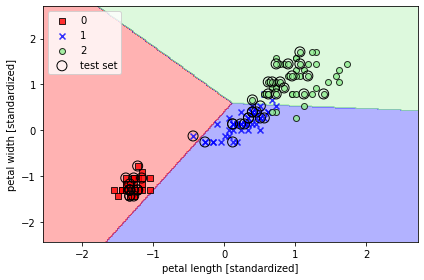

In [9]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std, y=y_combined, classifier=ppn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [10]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

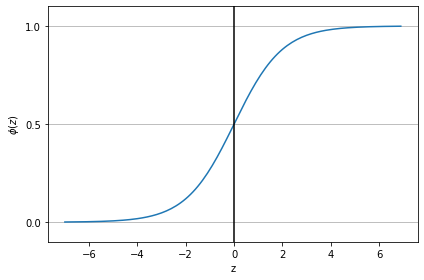

In [11]:
z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)
plt.plot(z, phi_z)
plt.axvline(0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi(z)$')
plt.yticks([0, 0.5, 1])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

In [12]:
def cost_1(z):
    return -np.log(sigmoid(z))

In [13]:
def cost_0(z):
    return -np.log(1 - sigmoid(z))

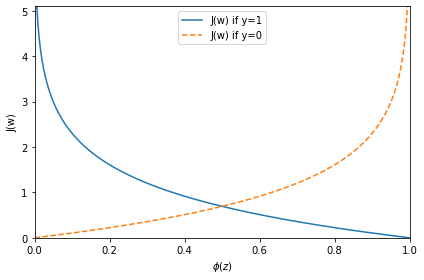

In [14]:
z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)
c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')
c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')
plt.ylim(0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi(z)$')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [15]:
class LogisticRegressionGD(object):
    """Logistic Regression Classifier using gradient descent.
    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.
    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Logistic cost function value in each epoch.
    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.
        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # equivalent to:
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

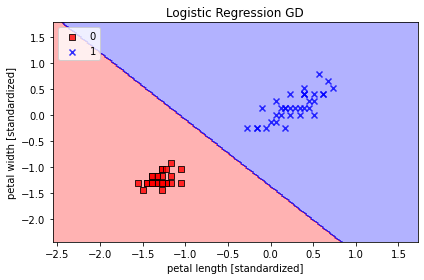

In [16]:
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]
lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset, y_train_01_subset)
plot_decision_regions(X=X_train_01_subset, y=y_train_01_subset, classifier=lrgd)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.title('Logistic Regression GD')
plt.tight_layout()
plt.show()

Accuracy: 0.978
Probabilities: 
 [[3.81527885e-09 1.44792866e-01 8.55207131e-01]
 [8.34020679e-01 1.65979321e-01 3.25737138e-13]
 [8.48831425e-01 1.51168575e-01 2.62277619e-14]]
Class with max probability: 
 [2 0 0]
Class with predict method: 
 [2 0 0]


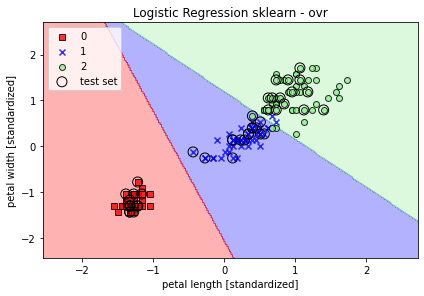

In [46]:
lr_ovr = LogisticRegression(C=100, random_state=1, solver='lbfgs', multi_class='ovr')
lr_ovr.fit(X_train_std, y_train)
print('Accuracy: %.3f' % lr_ovr.score(X_test_std, y_test))
print('Probabilities: \n', lr_ovr.predict_proba(X_test_std[:3, :]))
print('Class with max probability: \n', lr_ovr.predict_proba(X_test_std[:3, :]).argmax(axis=1))
print('Class with predict method: \n', lr_ovr.predict(X_test_std[:3, :]))
plot_decision_regions(X_combined_std, y_combined, classifier=lr_ovr, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.title('Logistic Regression sklearn - ovr')
plt.show()

Accuracy: 0.978
Probabilities: 
 [[1.52213484e-12 3.85303417e-04 9.99614697e-01]
 [9.93560717e-01 6.43928295e-03 1.14112016e-15]
 [9.98655228e-01 1.34477208e-03 1.76178271e-17]]
Class with max probability: 
 [2 0 0]
Class with predict method: 
 [2 0 0]


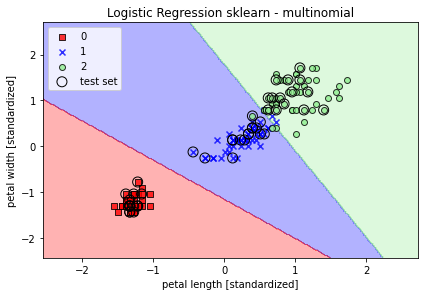

In [47]:
lr_multinomial = LogisticRegression(C=100, random_state=1, solver='lbfgs', multi_class='multinomial')
lr_multinomial.fit(X_train_std, y_train)
print('Accuracy: %.3f' % lr_multinomial.score(X_test_std, y_test))
print('Probabilities: \n', lr_multinomial.predict_proba(X_test_std[:3, :]))
print('Class with max probability: \n', lr_multinomial.predict_proba(X_test_std[:3, :]).argmax(axis=1))
print('Class with predict method: \n', lr_multinomial.predict(X_test_std[:3, :]))
plot_decision_regions(X_combined_std, y_combined, classifier=lr_multinomial, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.title('Logistic Regression sklearn - multinomial')
plt.show()

In [49]:
# predict single row
lr_ovr.predict(X_test_std[0, :].reshape(1, -1))

array([2])

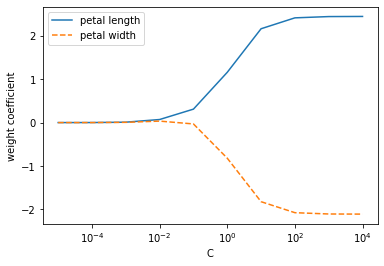

In [54]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, random_state=1, solver='lbfgs', multi_class='ovr')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)
weights = np.array(weights)
plt.plot(params, weights[:, 0], label='petal length')
plt.plot(params, weights[:, 1], linestyle='--', label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()